# Project 8: CNN

## Instructions

### Description

In this project you will be learning about Convolutional Neural Networks (CNN) and messing with the parameters to see how they can change the output of the CNN. You will start with some questions about Tensorflow, the python package used for CNN! Good luck!

### Grading

For grading purposes, we will clear all outputs from all your cells and then run them all from the top.  Please test your notebook in the same fashion before turning it in.

### Submitting Your Solution

To submit your notebook, first clear all the cells (this won't matter too much this time, but for larger data sets in the future, it will make the file smaller).  Then use the File->Download As->Notebook to obtain the notebook file.  Finally, submit the notebook file on Canvas.


## 40 points

### Instructions
- The **"MNIST" data set** is composed of 28x28 pixel, black and white images of handwritten digits (0-9). It is commonly used to demonstrate the training and testing of CNNs.
- **We provide you with framework code** to build a CNN of roughly suitable size for the MNIST digit recognition task.


- **Your tasks**:
    1. Read the linked article and answer the questions under the "What is Tensorflow" section
    2. **Execute the train/test code** and observe the results of the gradient descent training.
    3. Complete all 4 modifications of the code, thee modification instructions are:
         - **Modify the model architecture in the following ways**, and repeat the training and testing. Each modification should be made relative to the original network. Do not keep "adding" each modification with each new model (which would lead to a final model having all the modifications below):
           - **Modification 1**: Remove the ReLU activation functions and the max-pooling layers, thereby making the entire network a linear function.
           - **Modification 2**: Increase the size of the model by a factor of 16, roughly.
           - **Modification 3**: Convert the large convolutional model to a large non-convolutional model, with roughly the same number of parameters.
           - **Modification 4**: Train the original baseline model with a larger training data set. 
     4. MAKE SURE THAT: along the way, **answer the questions in the Jupyter notebook cells**. You can just do this with comments within the cell, for example...
   - ```## Answer 1: The training loss increased when I did x, y, and z.```

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import time

np.random.seed(0)
tf.random.set_seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install tensorflow-macos
!pip install tensorflow-metal

ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


# Part 1
## What is TensorFlow? (6 pts)

Before we get started with the rest of the project, let's talk about what tensorflow is. You are required to read this article https://www.guru99.com/what-is-tensorflow.html, and answer the following questions:

1. What are the three parts of the TensorFlow Architecture?

2. What is a Tensor and how does it represent data?

3. What is one advantage of the use of graphs in TensorFlow?


# Part 2
## Set TensorFlow verbosity level

In [3]:
verbose = 2 # 0==no output, 1=accuracy/loss output, 2=progress bar output

## Create helper function to plot results of our model training

In [4]:
def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

## Load the MNIST data

### You will not need to re-run or re-use (cut/paste) the three code cells below.

The full dataset has 60,000 training images and 10,000 test images.

To accelerate training on jupyterhub (with lots of users) we will only  
use a subset of the training set. This will also let us explore some of the  
hazards of training a neural net without a very large set of samples.

In [5]:
# Load data
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

# Use a subset of the full training and test sets for actual training and testing,
# to accelerate training, and demonstrate possible pitfalls of smaller training data sets.

n_train = 1000
images_train = images_train[0:n_train,:,:]
labels_train = labels_train[0:n_train]

n_test = 1000
images_test = images_test[0:n_test,:,:]
labels_test = labels_test[0:n_train]

## Let's graph a few of the MNIST digits, to confirm that they look as expected

Using plt.imshow(), graph the first sixteen numbers in the training images.

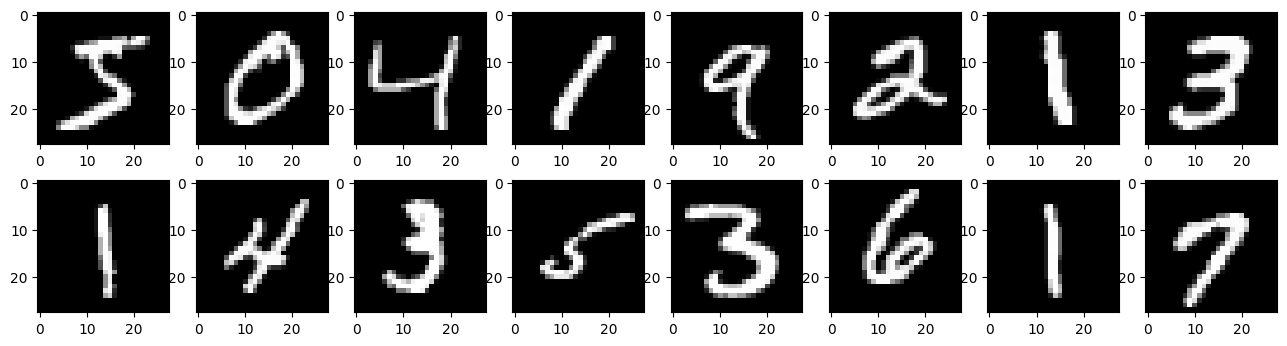

In [6]:
## You will not need to run this cell more than once, or cut/paste it elsewhere
plt.figure(figsize=(8*2, 2*2))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(images_train[i,:,:], cmap='gray')

In [7]:
# Create TensorFlow Dataset objects to hold train and test data.
images_train = images_train/255 
images_train = np.expand_dims(images_train, axis=3) # TensorFlow expects a channel dimension
images_train = tf.cast(images_train, tf.float32)
labels_train = tf.cast(labels_train, tf.float32)
dataset_train = tf.data.Dataset.from_tensor_slices((images_train, labels_train))

images_test = images_test/255
images_test = np.expand_dims(images_test, axis=3) # TensorFlow expects a channel dimension
images_test = tf.cast(images_test, tf.float32)
labels_test = tf.cast(labels_test, tf.float32)
dataset_test = tf.data.Dataset.from_tensor_slices((images_test, labels_test))

batch_size = 50

dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(n_train)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

dataset_test = dataset_test.cache()
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.cache()
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

## Construct, compile, and train the baseline model. (4 pts)


The code will plot the loss and accuracy scores that were collected during training. Remember that training uses gradient descent, so the model parameters are slowly updated as the model gets a closer and closer fit to the data. TensorFlow records the scores after each "epoch"--the number of iterations at which all samples in the training set have been used once, in the gradient descent process.

We are now going to build teh model. In tensorflow, we build the model by first defining all the layers that the model is going to have, then we compile the model. Finally, we can train the model. We are going to define the model first. The rest is taken care of for you. 

We do this by calling `tf.keras.models.Sequential()` and inputting the list of layers, in order, as the parameter. Our baseline model is going to include two convalutional layers with pooling layers after each one, then we are going to have one dense layer with 64 neurons. It will then conclude with a dense layer of 10 that is our output layer. (Hint, you need to reduce the dimensionality before the data enters the neural network part of the model!)

The following are names of layers that may be useful: 

  `tf.keras.layers.Conv2D()`

  `tf.keras.layers.MaxPool2D()`

  `tf.keras.layers.Flatten()`

  `tf.keras.layers.Dense()`

For our model, we want to make sure that our convolutional layers have a kernel size of 3x3, 4 kernels, and use the 'relu' activation. Our pooling layers are going to have a 2x2 pooling same and `padding='same'`.   Don't foget to add the relu activation to the dense layer with 64 neurons. 

More information about the layers can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers)!


Epoch 1/30
20/20 - 0s - loss: 2.2369 - accuracy: 0.2440 - val_loss: 2.1441 - val_accuracy: 0.3730 - 255ms/epoch - 13ms/step
Epoch 2/30
20/20 - 0s - loss: 1.9714 - accuracy: 0.4780 - val_loss: 1.7958 - val_accuracy: 0.5710 - 57ms/epoch - 3ms/step
Epoch 3/30
20/20 - 0s - loss: 1.4686 - accuracy: 0.6720 - val_loss: 1.2909 - val_accuracy: 0.6310 - 58ms/epoch - 3ms/step
Epoch 4/30
20/20 - 0s - loss: 0.9611 - accuracy: 0.7690 - val_loss: 0.9424 - val_accuracy: 0.7100 - 58ms/epoch - 3ms/step
Epoch 5/30
20/20 - 0s - loss: 0.6913 - accuracy: 0.8050 - val_loss: 0.7684 - val_accuracy: 0.7510 - 57ms/epoch - 3ms/step
Epoch 6/30
20/20 - 0s - loss: 0.5691 - accuracy: 0.8380 - val_loss: 0.7403 - val_accuracy: 0.7470 - 59ms/epoch - 3ms/step
Epoch 7/30
20/20 - 0s - loss: 0.4973 - accuracy: 0.8610 - val_loss: 0.6540 - val_accuracy: 0.7730 - 60ms/epoch - 3ms/step
Epoch 8/30
20/20 - 0s - loss: 0.4368 - accuracy: 0.8630 - val_loss: 0.6093 - val_accuracy: 0.7880 - 61ms/epoch - 3ms/step
Epoch 9/30
20/20 - 0s 

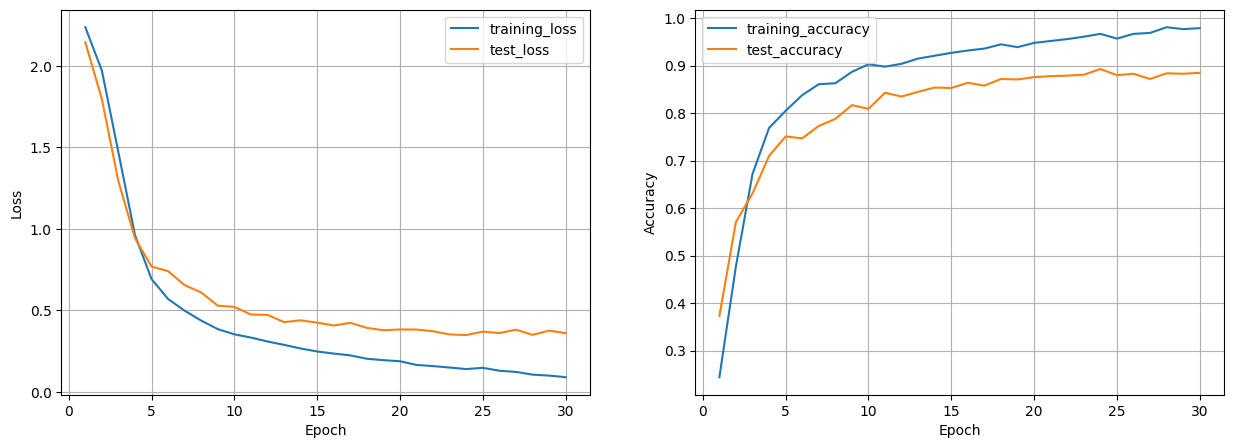

In [8]:
## This is the baseline model. 

##Your Code goe here
num_kernels = 4
dense_layer_neurons = 64
kernels_size = (3, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    
    optimizer='adam',                # TODO: please note I am using a mac and the optimizer you selected isn't as fast so I am using a better version of adam. optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

## Part 2 Questions (6 pts)

### Using the baseline model, answer the questions below

In [9]:
##Assume one image is pushed through as the sole input, and asnwer with three dimensions.

##(Hint: The default stride for MaxPool2D is 2, and the default stride for Conv2D is 1!)

##Questions 1: What is the dimensionality of the input before it has gone through any layers?
##Question 2: What is its dimensionality after passing through the first convulational layer?
##Question 3: What is its dimensionality after passing through the first convulational layer and the first pooling layer?

##Answer 1: 
## it takes an input of 28 by 28 by 1 the first two dimentions are for the x and y axis and the final dimension is for the color.
##Answer 2: 
##26x26x4
##Answer 3:
##13x13x4

## MODIFICATION 1 (6 pts)

### Copy code from cell above, that builds and trains the baseline model, and plots the results.
### Now alter the model as described below, and run the code.
Alter the model by removing the ReLU and max-pooling non-linear activations.  

Epoch 1/30
20/20 - 0s - loss: 1.3888 - accuracy: 0.5990 - val_loss: 0.8551 - val_accuracy: 0.7340 - 286ms/epoch - 14ms/step
Epoch 2/30
20/20 - 0s - loss: 0.4668 - accuracy: 0.8670 - val_loss: 0.5605 - val_accuracy: 0.8180 - 65ms/epoch - 3ms/step
Epoch 3/30
20/20 - 0s - loss: 0.3003 - accuracy: 0.9140 - val_loss: 0.5367 - val_accuracy: 0.8310 - 68ms/epoch - 3ms/step
Epoch 4/30
20/20 - 0s - loss: 0.2157 - accuracy: 0.9380 - val_loss: 0.5359 - val_accuracy: 0.8250 - 67ms/epoch - 3ms/step
Epoch 5/30
20/20 - 0s - loss: 0.1739 - accuracy: 0.9530 - val_loss: 0.5550 - val_accuracy: 0.8200 - 66ms/epoch - 3ms/step
Epoch 6/30
20/20 - 0s - loss: 0.1287 - accuracy: 0.9650 - val_loss: 0.5643 - val_accuracy: 0.8290 - 67ms/epoch - 3ms/step
Epoch 7/30
20/20 - 0s - loss: 0.0860 - accuracy: 0.9830 - val_loss: 0.5986 - val_accuracy: 0.8170 - 66ms/epoch - 3ms/step
Epoch 8/30
20/20 - 0s - loss: 0.0672 - accuracy: 0.9850 - val_loss: 0.6890 - val_accuracy: 0.8070 - 66ms/epoch - 3ms/step
Epoch 9/30
20/20 - 0s 

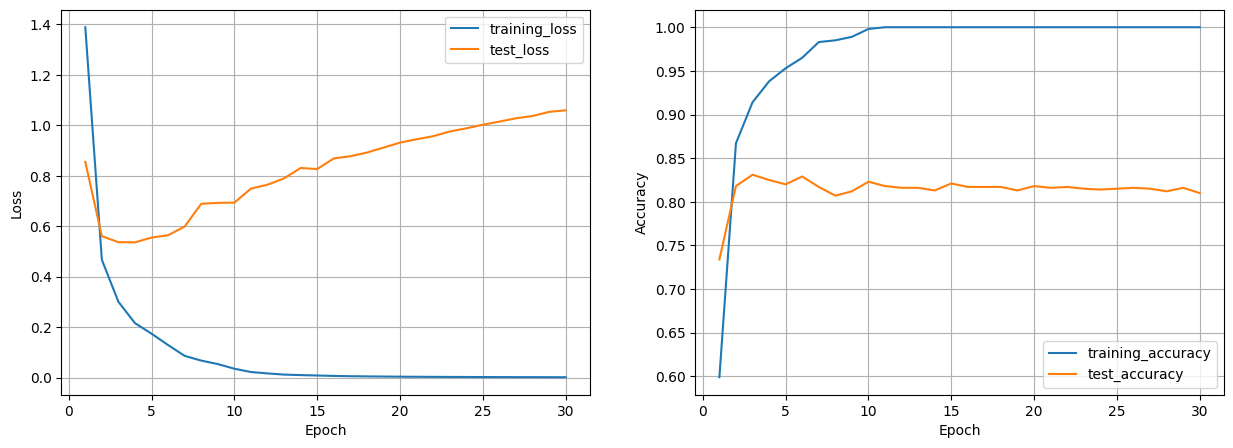

In [10]:
## MODIFICATION 1
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
#%tensorboard --logdir logs
num_kernels = 4
dense_layer_neurons = 64
kernels_size = (3, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size),
    tf.keras.layers.Conv2D(num_kernels, kernels_size),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(dense_layer_neurons),
    tf.keras.layers.Dense(10)
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

plot_results(history)

In [11]:
## MODIFICATION 1
## QUESTION 1: During training, how did the loss (error) curves change from the baseline model to the linear (MOD 1)
##             model, for both the training and test sets? What does this imply regarding underfitting or overfitting?
## QUESTION 2: In general, did the ReLU and max-pooling non-linearities make for a better model or a worse model?

## Answer 1:
##
## Answer 2:
##

## MODIFICATION 2 (6 pts)

### Copy code from the baseline model, for building, training, and plotting results.
### Now alter the model as described below, and run the code.

Make the network much larger, by:
1. Increasing the number of kernels in the convolutional layers from 4 to 64 (16x).
2. Increasing the number neurons in the dense layer from 64 to 1024 (16x).

Epoch 1/30
20/20 - 0s - loss: 1.3179 - accuracy: 0.5650 - val_loss: 0.7809 - val_accuracy: 0.7600 - 416ms/epoch - 21ms/step
Epoch 2/30
20/20 - 0s - loss: 0.4308 - accuracy: 0.8650 - val_loss: 0.3808 - val_accuracy: 0.8840 - 246ms/epoch - 12ms/step
Epoch 3/30
20/20 - 0s - loss: 0.2257 - accuracy: 0.9470 - val_loss: 0.3574 - val_accuracy: 0.8870 - 254ms/epoch - 13ms/step
Epoch 4/30
20/20 - 0s - loss: 0.1604 - accuracy: 0.9560 - val_loss: 0.2391 - val_accuracy: 0.9170 - 252ms/epoch - 13ms/step
Epoch 5/30
20/20 - 0s - loss: 0.1046 - accuracy: 0.9680 - val_loss: 0.2354 - val_accuracy: 0.9300 - 253ms/epoch - 13ms/step
Epoch 6/30
20/20 - 0s - loss: 0.0688 - accuracy: 0.9820 - val_loss: 0.2158 - val_accuracy: 0.9330 - 260ms/epoch - 13ms/step
Epoch 7/30
20/20 - 0s - loss: 0.0389 - accuracy: 0.9900 - val_loss: 0.1890 - val_accuracy: 0.9350 - 257ms/epoch - 13ms/step
Epoch 8/30
20/20 - 0s - loss: 0.0241 - accuracy: 0.9950 - val_loss: 0.2223 - val_accuracy: 0.9320 - 256ms/epoch - 13ms/step
Epoch 9/

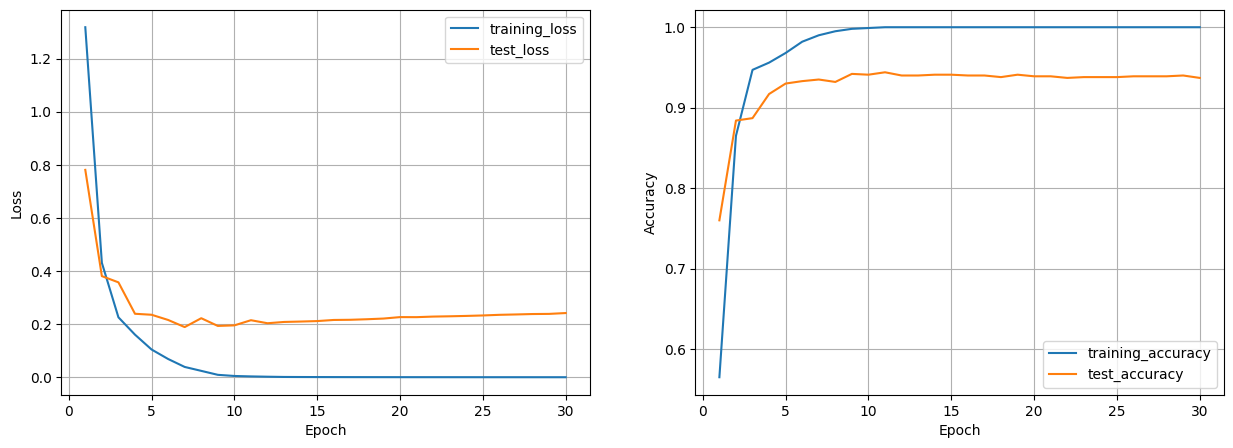

In [12]:
## MODIFICATION 2
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
##Your Code goe here
num_kernels = 64
dense_layer_neurons = 1024
kernels_size = (3, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

In [13]:
## MODIFICATION 2
## QUESTION 1: How did the performance of the larger model (MOD 2) compare to that of the baseline model?
## QUESTION 2: Based on the training curves, does the larger model show any **clear** signs of overfitting,
##             despite the large number of parameters?

## Answer 1:
##
## Answer 2:
##

## MODIFICATION 3 (6 pts)

### Copy code from the baseline model, for building, training, and plotting results.
### Now alter the model as described below, and run the code.

**Relative to the MOD 2 model**, remove the convolutional and max-pooling layers, replacing them with a single, new, dense layer.

The two convolutional layers have 640 and 36,928 parameters, respectively, for a total of 37,586.
For an input of 28x28 = 784 pixels (features), a dense layer with 48 neurons will have roughly 784x48 = 37,632 parameters. Thus, do the following:
1. Remove the convolutional and max-pooling layers.
2. After the Flatten() layer, add a new Dense layer with 48 neurons and a ReLU activation function.
3. Keep the (now second) Dense layer of dense_layer_neurons==1024 neurons, and the final Dense layer of 10 neurons.

Epoch 1/30
20/20 - 0s - loss: 1.8611 - accuracy: 0.4750 - val_loss: 1.2768 - val_accuracy: 0.6810 - 154ms/epoch - 8ms/step
Epoch 2/30
20/20 - 0s - loss: 0.7169 - accuracy: 0.8080 - val_loss: 0.6870 - val_accuracy: 0.7710 - 26ms/epoch - 1ms/step
Epoch 3/30
20/20 - 0s - loss: 0.4184 - accuracy: 0.8750 - val_loss: 0.6051 - val_accuracy: 0.8060 - 26ms/epoch - 1ms/step
Epoch 4/30
20/20 - 0s - loss: 0.3092 - accuracy: 0.9150 - val_loss: 0.5346 - val_accuracy: 0.8170 - 27ms/epoch - 1ms/step
Epoch 5/30
20/20 - 0s - loss: 0.2363 - accuracy: 0.9300 - val_loss: 0.4590 - val_accuracy: 0.8420 - 28ms/epoch - 1ms/step
Epoch 6/30
20/20 - 0s - loss: 0.1790 - accuracy: 0.9490 - val_loss: 0.5072 - val_accuracy: 0.8360 - 30ms/epoch - 1ms/step
Epoch 7/30
20/20 - 0s - loss: 0.1423 - accuracy: 0.9620 - val_loss: 0.4821 - val_accuracy: 0.8530 - 31ms/epoch - 2ms/step
Epoch 8/30
20/20 - 0s - loss: 0.1154 - accuracy: 0.9680 - val_loss: 0.4870 - val_accuracy: 0.8480 - 30ms/epoch - 2ms/step
Epoch 9/30
20/20 - 0s -

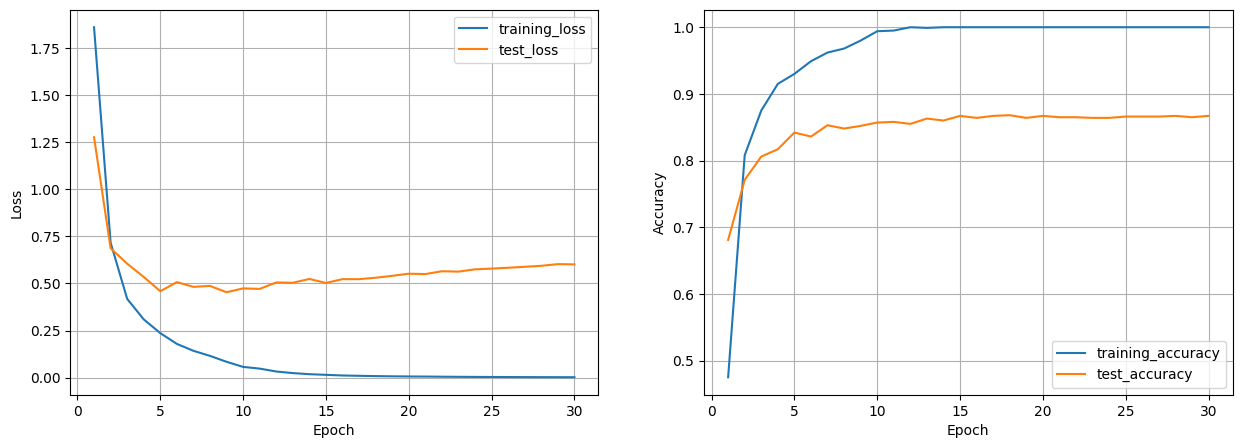

In [14]:
## MODIFICATION 3
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
num_kernels = 4
dense_layer_neurons = 1024
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # assuming the input image size is 28x28

    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

plot_results(history)

In [15]:
## MODIFICATION 3
## QUESTION 1: How did the performance of the large non-convolutional model (MOD 3) compare to that of the
##             large convolutional model (MOD 2)?
## QUESTION 2: Speculate on why the convolutional model performs better or worse than the non-convolutional model.
##             There is a "right" answer, but we're just looking for your opinion/guess. No penalty for error.

## Answer 1:
##
## Answer 2:
##

## MODIFICATION 4 (6 pts)

## This model/data with take longer to train the the previous ones--upwards of several minutes.

### For the modification, we don't modify the model, we modify the size of the data sets. The two cells below create training and testing sets with 10,000 samples each, whereas our previous models used only 1,000 samples each.

### Copy code from the baseline model, for building, training, and plotting results.
- Place the copied code after the two cells below.  
- Run all the cells below to get the new data sets, and train the baseline model on that data.

In [16]:
# Load data
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

# Use a subset of the full training and test sets for actual training and testing,
# to accelerate training, and demonstrate possible pitfalls of smaller training data sets.

n_train = 10000
images_train = images_train[0:n_train,:,:]
labels_train = labels_train[0:n_train]

n_test = 10000
images_test = images_test[0:n_test,:,:]
labels_test = labels_test[0:n_train]

In [17]:
# Create TensorFlow Dataset objects to hold train and test data.
images_train = images_train/255
images_train = np.expand_dims(images_train, axis=3) # TensorFlow expects a channel dimension
images_train = tf.cast(images_train, tf.float32)
labels_train = tf.cast(labels_train, tf.float32)
dataset_train = tf.data.Dataset.from_tensor_slices((images_train, labels_train))

images_test = images_test/255
images_test = np.expand_dims(images_test, axis=3) # TensorFlow expects a channel dimension
images_test = tf.cast(images_test, tf.float32)
labels_test = tf.cast(labels_test, tf.float32)
dataset_test = tf.data.Dataset.from_tensor_slices((images_test, labels_test))

dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(n_train)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

dataset_test = dataset_test.cache()
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.cache()
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

Epoch 1/30
200/200 - 1s - loss: 1.1033 - accuracy: 0.6832 - val_loss: 0.4071 - val_accuracy: 0.8817 - 720ms/epoch - 4ms/step
Epoch 2/30
200/200 - 1s - loss: 0.3303 - accuracy: 0.9011 - val_loss: 0.2708 - val_accuracy: 0.9183 - 576ms/epoch - 3ms/step
Epoch 3/30
200/200 - 1s - loss: 0.2458 - accuracy: 0.9273 - val_loss: 0.2370 - val_accuracy: 0.9266 - 592ms/epoch - 3ms/step
Epoch 4/30
200/200 - 1s - loss: 0.2099 - accuracy: 0.9346 - val_loss: 0.1972 - val_accuracy: 0.9381 - 600ms/epoch - 3ms/step
Epoch 5/30
200/200 - 1s - loss: 0.1825 - accuracy: 0.9455 - val_loss: 0.1725 - val_accuracy: 0.9490 - 593ms/epoch - 3ms/step
Epoch 6/30
200/200 - 1s - loss: 0.1581 - accuracy: 0.9521 - val_loss: 0.1659 - val_accuracy: 0.9493 - 617ms/epoch - 3ms/step
Epoch 7/30
200/200 - 1s - loss: 0.1394 - accuracy: 0.9577 - val_loss: 0.1503 - val_accuracy: 0.9521 - 579ms/epoch - 3ms/step
Epoch 8/30
200/200 - 1s - loss: 0.1228 - accuracy: 0.9626 - val_loss: 0.1389 - val_accuracy: 0.9559 - 563ms/epoch - 3ms/step


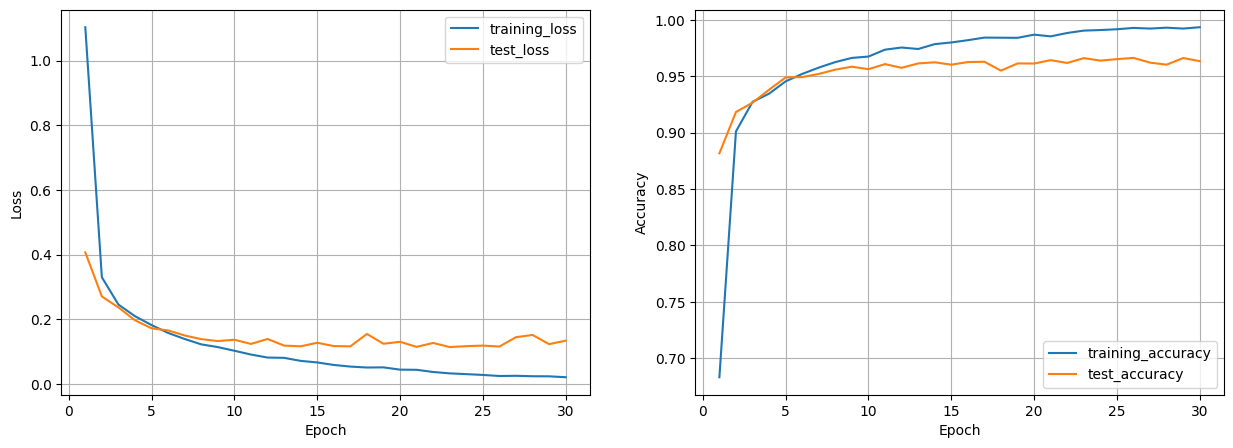

In [18]:
## MODIFICATION 4
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
## This is the baseline model. 

##Your Code goe here
num_kernels = 4
dense_layer_neurons = 64
kernels_size = (3, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

In [19]:
## MODIFICATION 4
## QUESTION 1: How did the performance of the baseline model trained on the larger data set (MOD 4) compare
##             to that trained on the smaller data set?
## QUESTION 2: This is just guess on your part... how much better do you think results might be if you trained
##             the model on all 60,000 training samples (rather than 1000 or 10,000)?

## Answer 1:
##
## Answer 2:
##

### Questionnaire
1) How long did you spend on this assignment?
<br><br>
2) What did you like about it? What did you not like about it?
<br><br>
3) Did you find any errors or is there anything you would like changed?
<br><br>